In [1]:
# import libraries

import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import random


In [ ]:
# Set random seed
np.random.seed(42)

## Place Pokemon PNG Files on a Randomly Selected Natural Background

In [2]:
POKE_DIR       = r"pokemon_png"
BG_DIR         = r"backgrounds"
OUT_DIR        = r"pokemon_bg"
NUM_BGS        = 1824        # only use the first 1824 backgrounds
FLIP_PROB      = 0.5         # probability of horizontal flip
POKE_SCALE_MIN = 0.10        # 10% of bg width
POKE_SCALE_MAX = 0.40        # 40% of bg width

def main():
    # Gather file lists
    poke_files = sorted([f for f in os.listdir(POKE_DIR)
                         if f.lower().endswith('.png')])
    bg_files   = sorted([f for f in os.listdir(BG_DIR)
                         if f.lower().endswith(('.jpg','jpeg'))])[:NUM_BGS]

    if not poke_files:
        raise RuntimeError("No Pokémon PNGs found in pokemon_png/")
    if not bg_files:
        raise RuntimeError("No background JPGs found in backgrounds/")

    # Prepare output directory
    os.makedirs(OUT_DIR, exist_ok=True)

    total = len(poke_files)
    for i, poke_name in enumerate(poke_files, start=1):
        # Load the Pokémon sprite (with alpha)
        poke_path = os.path.join(POKE_DIR, poke_name)
        poke = Image.open(poke_path).convert("RGBA")

        # Random horizontal flip
        if random.random() < FLIP_PROB:
            poke = poke.transpose(Image.FLIP_LEFT_RIGHT)

        # Pick & load a random background
        bg_name = random.choice(bg_files)
        bg_path = os.path.join(BG_DIR, bg_name)
        bg = Image.open(bg_path).convert("RGBA")
        bg_w, bg_h = bg.size

        # Random scale
        scale = random.uniform(POKE_SCALE_MIN, POKE_SCALE_MAX)
        new_w = int(bg_w * scale)
        # Keep aspect ratio
        w0, h0 = poke.size
        new_h = int(h0 * (new_w / w0))
        poke = poke.resize((new_w, new_h), Image.LANCZOS)

        # Random position
        max_x = bg_w - new_w
        max_y = bg_h - new_h
        x = random.randint(0, max_x) if max_x > 0 else 0
        y = random.randint(0, max_y) if max_y > 0 else 0

        # Composite images
        canvas = bg.copy()
        canvas.alpha_composite(poke, (x, y))

        # Save as JPEG
        base, _ = os.path.splitext(poke_name)
        out_name = f"{base}_bg.jpg"
        out_path = os.path.join(OUT_DIR, out_name)
        canvas.convert("RGB").save(out_path, "JPEG", quality=90)

        print(f"[{i}/{total}] {poke_name} on {bg_name} → {out_name}")

if __name__ == "__main__":
    main()


[1/819] 1.png on 00000040_(6).jpg → 1_bg.jpg
[2/819] 10.png on 00000295_(3).jpg → 10_bg.jpg
[3/819] 100.png on 00000128_(5).jpg → 100_bg.jpg
[4/819] 101.png on 00000219_(3).jpg → 101_bg.jpg
[5/819] 102.png on 00000101_(3).jpg → 102_bg.jpg
[6/819] 103.png on 00000266_(2).jpg → 103_bg.jpg
[7/819] 104.png on 00000274_(2).jpg → 104_bg.jpg
[8/819] 105.png on 00000138_(5).jpg → 105_bg.jpg
[9/819] 106.png on 00000247_(3).jpg → 106_bg.jpg
[10/819] 107.png on 00000214_(2).jpg → 107_bg.jpg
[11/819] 108.png on 00000171_(4).jpg → 108_bg.jpg
[12/819] 109.png on 00000006.jpg → 109_bg.jpg
[13/819] 11.png on 00000067_(7).jpg → 11_bg.jpg
[14/819] 110.png on 00000024_(4).jpg → 110_bg.jpg
[15/819] 111.png on 00000066_(6).jpg → 111_bg.jpg
[16/819] 112.png on 00000149_(3).jpg → 112_bg.jpg
[17/819] 113.png on 00000170_(5).jpg → 113_bg.jpg
[18/819] 114.png on 00000278.jpg → 114_bg.jpg
[19/819] 115-mega.png on 00000049.jpg → 115-mega_bg.jpg
[20/819] 115.png on 00000300_(6).jpg → 115_bg.jpg
[21/819] 116.png on

## Resizing Images

In [3]:
# File Directory holding all of the files for this project
INPUT_ROOT   = r""

# Specific folders holder the training and testing images
SPLITS = [
    "pokemon_train",
    "pokemon_test",
    "animals_train",
    "animals_test",
]
TARGET_SIZE = (224, 224)

# Ensures that all images are the same size so the model doesn't learn if it is a pokemon or not based on image size
def batch_resize_inplace():
    for split in SPLITS:
        dirpath = os.path.join(INPUT_ROOT, split)
        files = [f for f in os.listdir(dirpath)
                 if f.lower().endswith((".jpg", ".jpeg", ".png"))]
        print(f"Resizing {len(files)} images in {split}/ (in-place)...")

        for fname in files:
            path = os.path.join(dirpath, fname)
            with Image.open(path) as img:
                img = img.convert("RGB")
                img = img.resize(TARGET_SIZE, Image.LANCZOS)
                new_path = os.path.splitext(path)[0] + ".jpg"
                img.save(new_path, "JPEG", quality=90)
                if path.lower().endswith(".png"):
                    os.remove(path)

        print(f"  → Done {split}\n")

if __name__ == "__main__":
    batch_resize_inplace()


Resizing 655 images in pokemon_train/ (in-place)...
  → Done pokemon_train

Resizing 164 images in pokemon_test/ (in-place)...
  → Done pokemon_test

Resizing 655 images in animals_train/ (in-place)...
  → Done animals_train

Resizing 164 images in animals_test/ (in-place)...
  → Done animals_test



## Binary MLPClassifier: Pokemon vs Non-Pokemon

Train: X = (1310, 150528), y = (1310,)
Test: X = (328, 150528), y = (328,)
Train samples: 1310, Test samples: 328
Fitting MLPClassifier on binary labels...


C:\Users\jacko\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


max_iter =  1 -> Test Accuracy = 0.5000, Loss = 4.7938
Confusion Matrix: 
[[164   0]
 [164   0]]
Fitting MLPClassifier on binary labels...


C:\Users\jacko\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  warnings.warn(


max_iter =  2 -> Test Accuracy = 0.5701, Loss = 3.2660
Confusion Matrix: 
[[ 30 134]
 [  7 157]]
Fitting MLPClassifier on binary labels...


C:\Users\jacko\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  warnings.warn(


max_iter =  3 -> Test Accuracy = 0.6189, Loss = 0.6316
Confusion Matrix: 
[[156   8]
 [117  47]]
Fitting MLPClassifier on binary labels...


C:\Users\jacko\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4) reached and the optimization hasn't converged yet.
  warnings.warn(


max_iter =  4 -> Test Accuracy = 0.7043, Loss = 0.5829
Confusion Matrix: 
[[ 90  74]
 [ 23 141]]
Fitting MLPClassifier on binary labels...


C:\Users\jacko\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


max_iter =  5 -> Test Accuracy = 0.7500, Loss = 0.9633
Confusion Matrix: 
[[135  29]
 [ 53 111]]
Fitting MLPClassifier on binary labels...


C:\Users\jacko\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


max_iter =  6 -> Test Accuracy = 0.5701, Loss = 0.7696
Confusion Matrix: 
[[ 26 138]
 [  3 161]]
Fitting MLPClassifier on binary labels...


C:\Users\jacko\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (7) reached and the optimization hasn't converged yet.
  warnings.warn(


max_iter =  7 -> Test Accuracy = 0.7713, Loss = 0.4121
Confusion Matrix: 
[[129  35]
 [ 40 124]]
Fitting MLPClassifier on binary labels...


C:\Users\jacko\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (8) reached and the optimization hasn't converged yet.
  warnings.warn(


max_iter =  8 -> Test Accuracy = 0.7683, Loss = 0.4361
Confusion Matrix: 
[[101  63]
 [ 13 151]]
Fitting MLPClassifier on binary labels...


C:\Users\jacko\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (9) reached and the optimization hasn't converged yet.
  warnings.warn(


max_iter =  9 -> Test Accuracy = 0.7835, Loss = 0.6569
Confusion Matrix: 
[[138  26]
 [ 45 119]]
Fitting MLPClassifier on binary labels...
max_iter = 10 -> Test Accuracy = 0.7805, Loss = 0.4468
Confusion Matrix: 
[[132  32]
 [ 40 124]]


C:\Users\jacko\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


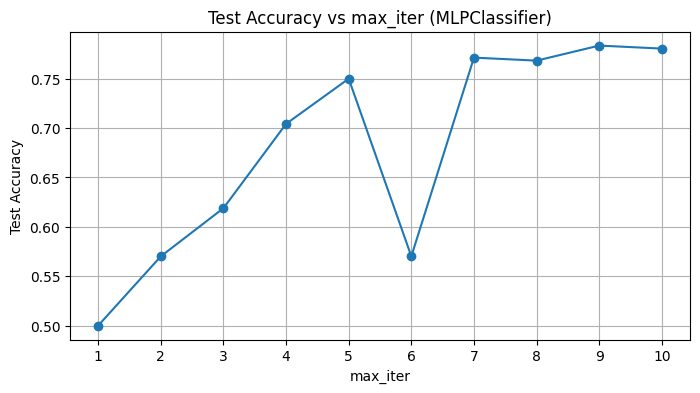

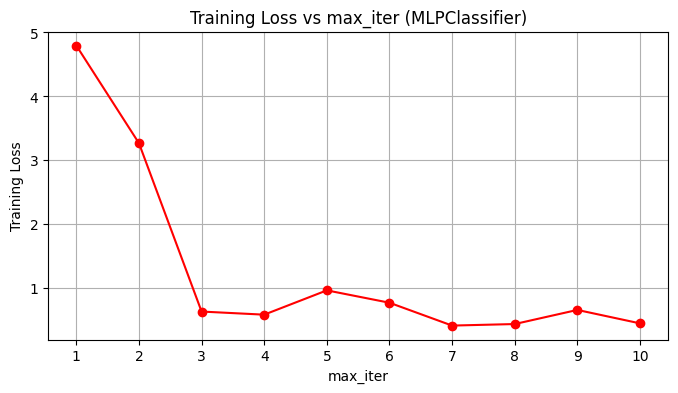

In [ ]:
# Folder Directories
DATA_ROOT       = r"C:\Users\jacko\Desktop\DAT494\FinalProject"
POKE_TRAIN_DIR  = "pokemon_train"
ANIM_TRAIN_DIR  = "animals_train"
POKE_TEST_DIR   = "pokemon_test"
ANIM_TEST_DIR   = "animals_test"

# Lets the code know if there is an image that wasn't sized properly
IMG_SIZE = (224,224)
# Batch sizes
BATCH_SIZE = 256
# Number of layers to not overr or under fit the model
HIDDEN_LAYERS = [32,32,32]
# Ensure random state for repeatability
RANDOM_STATE = 42

# This function builds my feature matrix and target vectors and ensures image size
def load_and_flatten(folder, label):
    X, y, paths = [], [], []

    for fname in sorted(os.listdir(folder)):
        if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
            continue
        path = os.path.join(folder, fname)
        img = Image.open(path).convert("RGB")
        
        if img.size != IMG_SIZE:
            raise ValueError(f"{path} is size {img.size}, expected  {IMG_SIZE}")
        
        arr = np.asarray(img, dtype=np.float32) / 255.0
        X.append(arr.ravel())
        y.append(label)
        paths.append(path)

    return np.vstack(X), np.array(y, dtype = np.int64), paths

# Assembles my full training datasets
x_poke_train, y_poke_train, _ = load_and_flatten(os.path.join(DATA_ROOT, POKE_TRAIN_DIR), 1)
x_anim_train, y_anim_train, _ = load_and_flatten(os.path.join(DATA_ROOT, ANIM_TRAIN_DIR), 0)
X_train = np.vstack([x_poke_train, x_anim_train])
y_train = np.concatenate([y_poke_train, y_anim_train])

# Assembles my full testing datasets
x_poke_test, y_poke_test, paths_poke_test = load_and_flatten(os.path.join(DATA_ROOT, POKE_TEST_DIR), 1)
x_anim_test, y_anim_test, paths_anim_test = load_and_flatten(os.path.join(DATA_ROOT, ANIM_TEST_DIR), 0)
X_test = np.vstack([x_poke_test, x_anim_test])
y_test = np.concatenate([y_poke_test, y_anim_test])
test_paths = paths_poke_test + paths_anim_test

# Shows the training and testing shapes to ensure it separated and counted correctly
print(f"Train: X = {X_train.shape}, y = {y_train.shape}")
print(f"Test: X = {X_test.shape}, y = {y_test.shape}")
print(f"Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

# Counts and captures max iterations, accuracy scores, and losses
max_iters = list(range(1, 11))
accuracies = []
loss = []

# Loop for running through 1-10 max iterations and grabbing 
for mi in max_iters:
    mlp_clf = MLPClassifier(
        hidden_layer_sizes = HIDDEN_LAYERS,
        activation = "relu",
        alpha = 0,
        max_iter = mi,
        batch_size = BATCH_SIZE,
        random_state = RANDOM_STATE,
        warm_start = False
    )

    # Fits the training set to the MLPClassifier
    print("Fitting MLPClassifier on binary labels...")
    mlp_clf.fit(X_train, y_train)

# Runs testing and outputs accuracy and loss
    y_pred = mlp_clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    loss.append(mlp_clf.loss_)
    cm = confusion_matrix(y_test, y_pred, labels = [0,1])
    print(f"max_iter = {mi:2d} -> Test Accuracy = {acc:.4f}, Loss = {mlp_clf.loss_:.4f}")
    print(f"Confusion Matrix: \n{cm}")

    

# Accuracy Graph
plt.figure(figsize = (8,4))
plt.plot(max_iters, accuracies, marker = 'o')
plt.title("Test Accuracy vs max_iter (MLPClassifier)")
plt.xlabel("max_iter")
plt.ylabel("Test Accuracy")
plt.xticks(max_iters)
plt.grid(True)
plt.show()

# Loss Graph
plt.figure(figsize = (8,4))
plt.plot(max_iters, loss, marker = 'o', color = 'red')
plt.title("Training Loss vs max_iter (MLPClassifier)")
plt.xlabel("max_iter")
plt.ylabel("Training Loss")
plt.xticks(max_iters)
plt.grid(True)
plt.show()

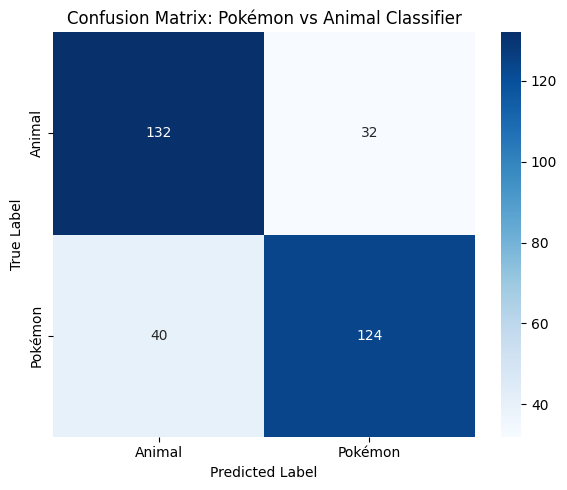

In [4]:
# Confusion Matrix

import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 2: Create the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Step 3: Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Animal', 'Pokémon'], yticklabels=['Animal', 'Pokémon'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix: Pokémon vs Animal Classifier")
plt.tight_layout()
plt.show()

Best max_iter = 9, Test Accuracy = 0.7835


C:\Users\jacko\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (9) reached and the optimization hasn't converged yet.
  warnings.warn(


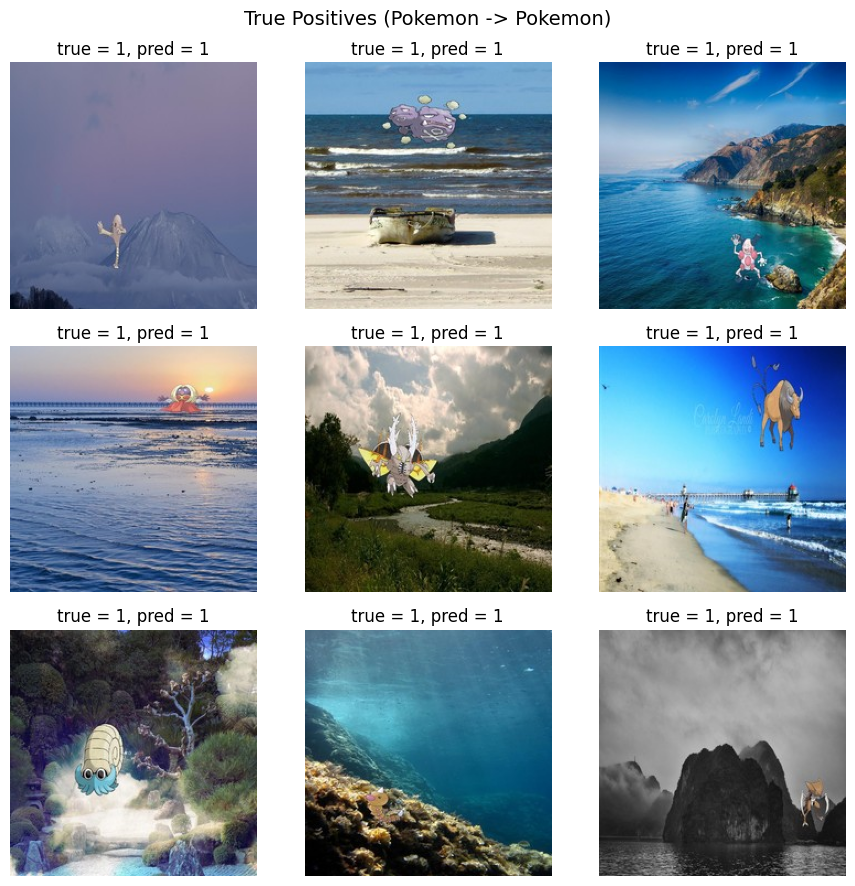

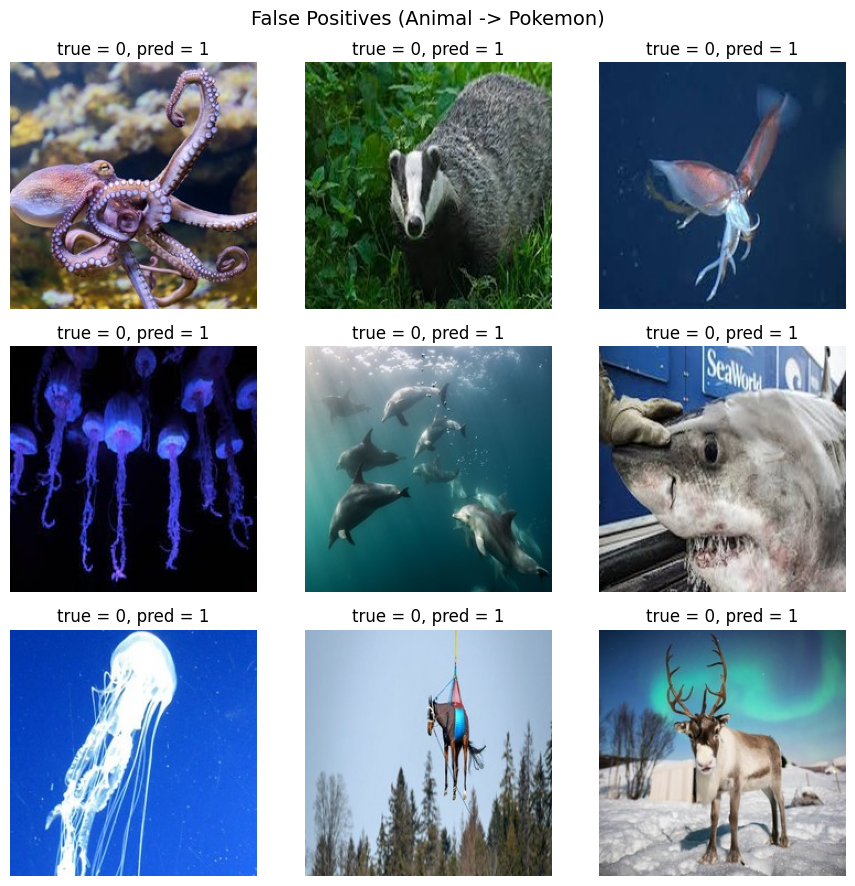

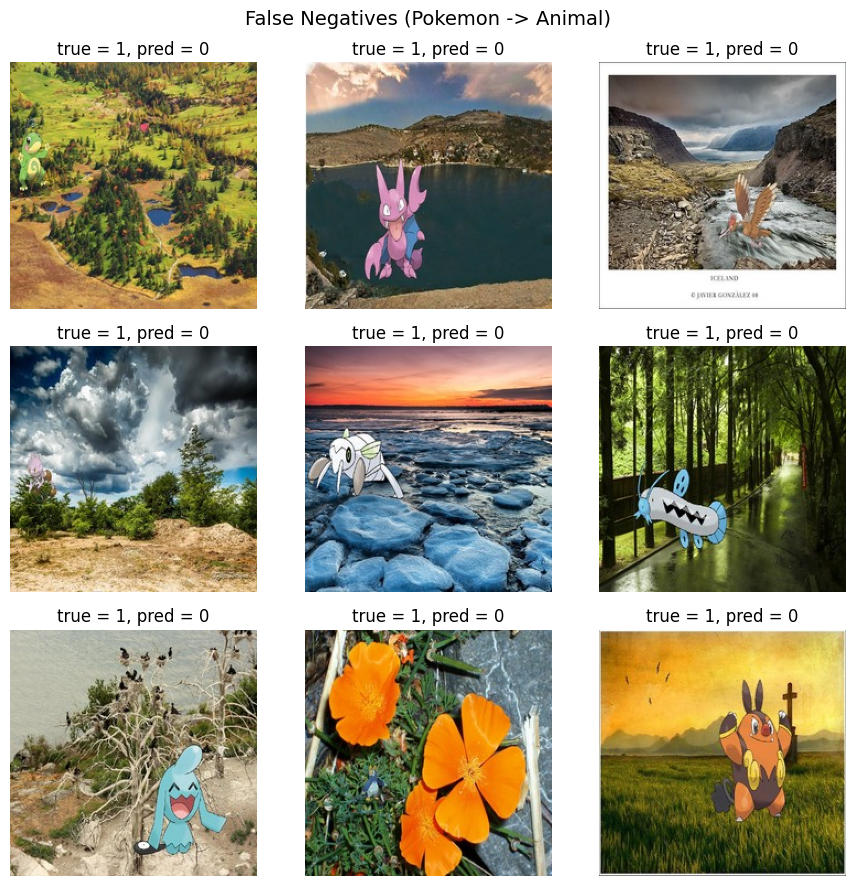

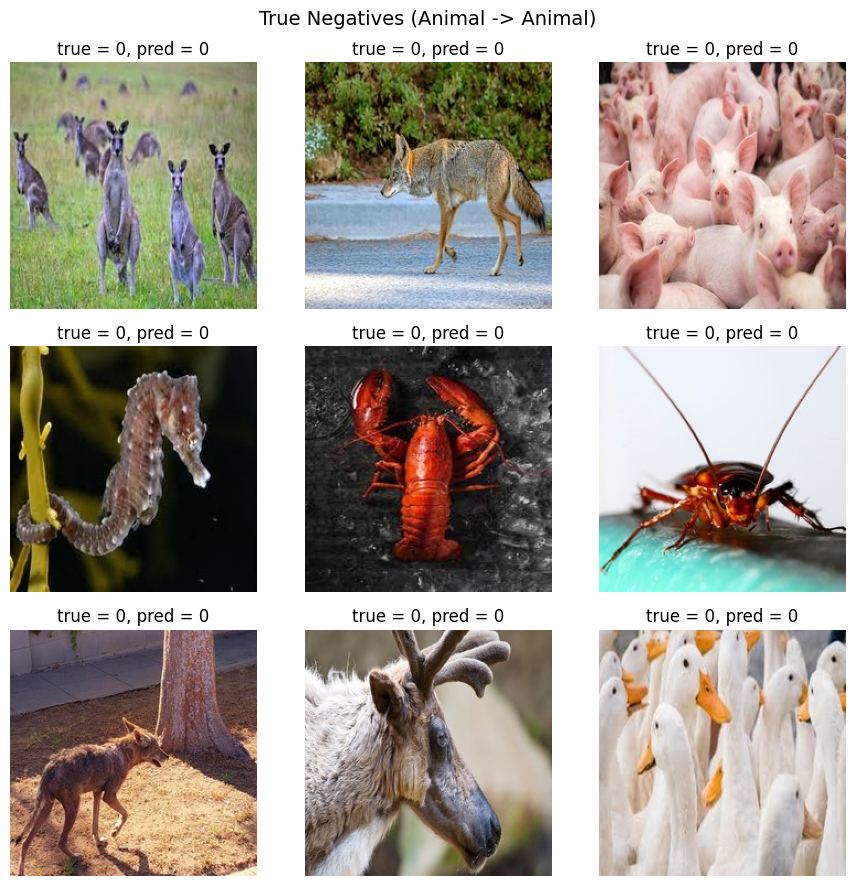

In [5]:
# Identify the best hyperparameter setting based on validation accuracy
best_idx = int(np.argmax(accuracies))              # Index of best-performing model
best_iter = max_iters[best_idx]                    # Corresponding number of iterations
print(f"Best max_iter = {best_iter}, Test Accuracy = {accuracies[best_idx]:.4f}")

# Rebuild the classifier using the best number of iterations
best_clf = MLPClassifier(
    hidden_layer_sizes=HIDDEN_LAYERS,
    activation="relu",
    alpha=0,
    max_iter=best_iter,
    batch_size=BATCH_SIZE,
    random_state=RANDOM_STATE,
    warm_start=False
)

# Fit the best model to the full training set
best_clf.fit(X_train, y_train)

# Predict labels on the test set
y_pred_best = best_clf.predict(X_test)

# Categorize predictions for analysis and visualization
categories = {
    "True Positives (Pokemon -> Pokemon)": [
        (p, yt, yp) for p, yt, yp in zip(test_paths, y_test, y_pred_best) if yt == 1 and yp == 1
    ],
    "False Positives (Animal -> Pokemon)": [
        (p, yt, yp) for p, yt, yp in zip(test_paths, y_test, y_pred_best) if yt == 0 and yp == 1
    ],
    "False Negatives (Pokemon -> Animal)": [
        (p, yt, yp) for p, yt, yp in zip(test_paths, y_test, y_pred_best) if yt == 1 and yp == 0
    ],
    "True Negatives (Animal -> Animal)": [
        (p, yt, yp) for p, yt, yp in zip(test_paths, y_test, y_pred_best) if yt == 0 and yp == 0
    ],
}

# Function to display sample images from each category
# Inputs:
#   - title: category name (e.g., "True Positives")
#   - items: list of (image path, true label, predicted label)
#   - max_samples: number of images to show (default: 9)

def plot_samples(title, items, max_samples=9):
    n = min(len(items), max_samples)
    cols = 3
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = axes.flatten()

    # Display each selected image with its labels
    for ax, (path, yt, yp) in zip(axes, items[:n]):
        img = Image.open(path).convert("RGB")
        ax.imshow(img)
        ax.set_title(f"true = {yt}, pred = {yp}")
        ax.axis("off")

    # Hide unused subplot axes
    for ax in axes[n:]:
        ax.axis("off")

    # Add overall title
    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Visualize predictions in each category (TP, FP, FN, TN)
for title, items in categories.items():
    plot_samples(title, items)
